<img src='../images/hanzi_hero_icon.png' style="float: left; margin: 20px; height: 55px">

# Hanzi Hero: Empowering Kids to Master Chinese Characters
<div style="text-align: right"> <H3> By Jayme Zhang </div>

---

## 6. Self-Trained CNN Model - Multiclass - Hyperparameters Tuning

In the previous notebook [05_SVM_Multiclass](05_SVM_Multiclass.ipynb), we have compiled the metrics for all baseline models and concluded that the self-trained CNN model is the best performing one. We will use this model to do hyperparameter tuning to further improve its performance.

Search results from Kera Tuner are saved in a separate folder and it can be downloaded from this [link](https://drive.google.com/drive/folders/1mb_Ejpj8TKNf_SxF6wMkzH2PUmvuOxUa?usp=sharing). Save the folder `keras_tuner_2` into this [`code` folder](/code/), and we are good to run this notebook.

---

The following sections are replicated from [03_Self_Trained_Model_Multiclass](03_Self_Trained_Model_Multiclass.ipynb):
  
- 3.1 Basic Setup
  
- 3.2 Image Augmentation
  
- 3.3 Reading Files from Directory
  
You may skip directly to the following to start the process of tuning of hyperparameters:
  
- 3.4.2 Fully Connected Layer - For Classification
  
- 3.6 Compile the Model
  
- 3.8 Visualize the Model Training
---

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import keras as keras
from keras import layers, initializers
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch

import time
import datetime, os

In [3]:
# tf.keras.backend.clear_session()

### 6.1 Basic Setup

#### 6.1.1 Set random seed

For easy comparison of results and debugging purposes, we will set up the following to ensure reproducibility of results.

In [4]:
# To ensure reproducibility of results
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

#### 6.1.2 Set font for output of Chinese characters

Since our labels include Chinese characters, for the characters to be displayed correctly on visualisations, we will set the fonts to be compatible.

In [5]:
# To check if the Chinese font for Simplified Chinese Songti is available
print([f for f in fm.fontManager.ttflist if 'Songti' in f.name])

[FontEntry(fname='/System/Library/Fonts/Supplemental/Songti.ttc', name='Songti SC', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')]


In [6]:
# To display Chinese characters in matplotlib
plt.rcParams['font.family'] = ['Songti SC']

### 6.2 Image Augmentation

We will be augmenting the images in the following ways:

1. We will rescale the image's pixels from between 0 to 255, to between 0.0 to 1.0, by dividing by 255. This would be a more direct and efficient approach compared to using StandardScalar().
  
2. The image can be rotated through any degree between 0 and 360. We will rotate the images by 10 degrees as there could be handwriting styles which are slanted to either left or right.

3. When the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in. The default value of 'nearest' will simply replace the empty area with the nearest pixel values.
  
4. To account for scenarios when the object may not always be in the centre of the image, we can shift the pixels of the image either horizontally or vertically. If the value is a float, that would represent the percentage of width or height of the image to shift. If it is an integer value, the width or height would shifted by that value of pixel values. In our case, we will shift it by 20%.

5. Shear transformation is a process of slanting the image. It is different from the rotation because in rotation we will rotate the image. But for shearing, we fix one axis and stretch the image in a certain angle known as the shearing angle. The value will be float which represents a shear angle in a counter-clockwise direction in degrees. We will shear by 20%.

6. The zoom augmentation will zoom in on the image for values smaller than 1, and zoom out on the image for values greater than 1. We will zoom in by 10%.

In [7]:
# Augmentation for training data
train_data = ImageDataGenerator(
    rescale=1./255, # normalize values to between 0 and 1
    rotation_range=10, # rotate image by 10 degrees
    fill_mode='nearest', # replaces empty area with the nearest pixel values
    width_shift_range=0.2, # shifts image width by 20%
    height_shift_range=0.2, # shifts image height by 20%
    shear_range=0.2, # shears image by 20%
    zoom_range=0.1 # zoom in image by 10%
)

# Validation data only requires normalizing of values to between 0 and 1
val_data = ImageDataGenerator(rescale=1./255)

### 6.3 Reading Files from Directory

Since all our dataset are images stored in individual folders, we will use `flow_from_directory` to specify that we want to read all files from a given directory. The directory should be set to the path where the various classes of folders are present.

At the same time, we are able to specify the following settings:

1. Since the images in the dataset are of diferring sizes, we will resize all image to (64, 64).  
  
2. We will set the images to 'grayscale'.

3. There will be 16 images yielded from the generator per batch.  
  
4. For this case, our `class_mode` will be set to categorical.  
  
5. We will set `shuffle` to True so that the order of the image that is being yielded will be shuffled. 

In [8]:
# To read in images from train folder
train_generator = train_data.flow_from_directory(
    '../data/multiclass_data/train',
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=16,
    class_mode='categorical', # categorical for multiclass model
    shuffle=True,
    seed=42
)

# To read in images from validation folder
val_generator = val_data.flow_from_directory(
    '../data/multiclass_data/valid',
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=16,
    class_mode='categorical', # categorical for multiclass model
    shuffle=False,
    seed=42
)

Found 5995 images belonging to 10 classes.
Found 1424 images belonging to 10 classes.


After reading in the images from the directory, we need to find out the labels allocated for different class.

In [9]:
# To find out labels for the 2 classes
train_generator.class_indices

{'你': 0,
 '吃': 1,
 '妈': 2,
 '家': 3,
 '我': 4,
 '爱': 5,
 '爸': 6,
 '的': 7,
 '衣': 8,
 '车': 9}

The results are returned in the form of a dictionary, where the Chinese character is the key and the index of the class is the value.

### 6.4 Tuning of Hyperparameters

We will be using KerasTuner for the purpose of hyperparameters tuning. It is an open-source library built on top of Keras, and is able to simplify and automate the process.  
  
We will start by defining a function which will return a compiled Keras model. It takes an argument `hp` for defining the hyperparameters while building the model.

In [10]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()
    
    # Tune number of units
    model.add(Conv2D(hp.Int('input_units',
                                min_value=32, 
                                max_value=256, #choose the input_channel parameter, randomly, between 32 and 256
                                step=32), #with a step of 32
                                (3, 3), 
                                padding='same',
                                input_shape=(64, 64, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Tune number of convolution layers
    for i in range(hp.Int('n_layers', 1, 4)):  # end-result of 2-5 layers
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    for i in range(hp.Int('n_connections', 1, 4)):
        # Tune number of nodes
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024])))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    # Define the optimizer learning rate as a hyperparameter
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'AUC'])

    return model

In [11]:
# Set up tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # how many model variations to test?
    executions_per_trial=2,  # how many trials per variation? (same model could perform differently)
    directory='keras_tuner_2',
    project_name='self_trained_multiclass_hyp') 

Reloading Tuner from keras_tuner_2/self_trained_multiclass_hyp/tuner0.json


In [12]:
# Summary of search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
n_connections (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
n_nodes (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512, 1024], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'lin

In [13]:
# Set number of epoch and batch size
epoch = 20
batch_size = 16

In [14]:
# Start the tuning
%time
tuner.search(train_generator,
            epochs=epoch,
            batch_size=batch_size,
            validation_data=val_generator
)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


### 6.5 Get the Best Model

After the long process for the search of the best hyperparameters, we want to obtain the summary and hyperparameters of the best model.

In [15]:
# Get the best model
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 160)       1600      
                                                                 
 activation (Activation)     (None, 64, 64, 160)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 160)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 224)       322784    
                                                                 
 activation_1 (Activation)   (None, 30, 30, 224)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 160)       322720    
                                                        

In [16]:
# To get hyperparameters for the best model
best_hp = tuner.get_best_hyperparameters()
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 160, 'n_layers': 2, 'conv_0_units': 224, 'n_connections': 2, 'n_nodes': 1024, 'lr': 0.000263474572751995, 'conv_1_units': 160, 'conv_2_units': 64, 'conv_3_units': 32}


### 6.6 Retrain Model with Best Hyperparameters

As seen before in [03_Self_Trained_Model_Multiclass](03_Self_Trained_Model_Multiclass.ipynb), we will make use of EarlyStopping to prevent overfitting during training.

In [17]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            mode='auto'
)

We will fit the model with the best hyperparameters.

In [18]:
# Fit model with best hyperparameters
history_best = best_model.fit(train_generator,
                        batch_size=batch_size,
                        validation_data=val_generator,
                        epochs=epoch,
                        callbacks=[early_stop]
                        )

Epoch 1/20


2024-05-10 04:36:59.907295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-10 04:36:59.965342: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


375/375 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9780 - auc: 0.9992

2024-05-10 04:38:51.979038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


375/375 [==============================] - 120s 320ms/step - loss: 0.0703 - accuracy: 0.9780 - auc: 0.9992 - val_loss: 0.0327 - val_accuracy: 0.9881 - val_auc: 0.9999
Epoch 2/20
375/375 [==============================] - 134s 356ms/step - loss: 0.0691 - accuracy: 0.9750 - auc: 0.9992 - val_loss: 0.0403 - val_accuracy: 0.9881 - val_auc: 0.9995
Epoch 3/20
375/375 [==============================] - 147s 392ms/step - loss: 0.0600 - accuracy: 0.9810 - auc: 0.9992 - val_loss: 0.0509 - val_accuracy: 0.9846 - val_auc: 0.9988
Epoch 4/20
375/375 [==============================] - 166s 444ms/step - loss: 0.0635 - accuracy: 0.9810 - auc: 0.9990 - val_loss: 0.0378 - val_accuracy: 0.9874 - val_auc: 0.9999
Epoch 5/20
375/375 [==============================] - 178s 473ms/step - loss: 0.0560 - accuracy: 0.9810 - auc: 0.9993 - val_loss: 0.0430 - val_accuracy: 0.9846 - val_auc: 0.9995
Epoch 6/20
375/375 [==============================] - 188s 500ms/step - loss: 0.0632 - accuracy: 0.9793 - auc: 0.9992 - v

### 6.7 Visualize the Model Training

#### 6.7.1 Loss over training epochs

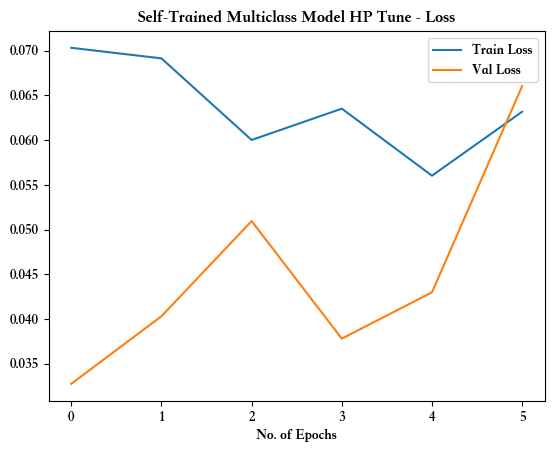

In [21]:
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Val Loss')
plt.title('Self-Trained Multiclass Model HP Tune - Loss')
plt.xlabel('No. of Epochs')
plt.legend();

The validation loss measures the difference between the predicted values and the actual values in the validation dataset. A lower validation loss indicates that the model's predictions are closer to the actual values. In this case, the validation loss is very close to the training loss, which means the model is performing well.

#### 6.7.2 Accuracy over training epochs

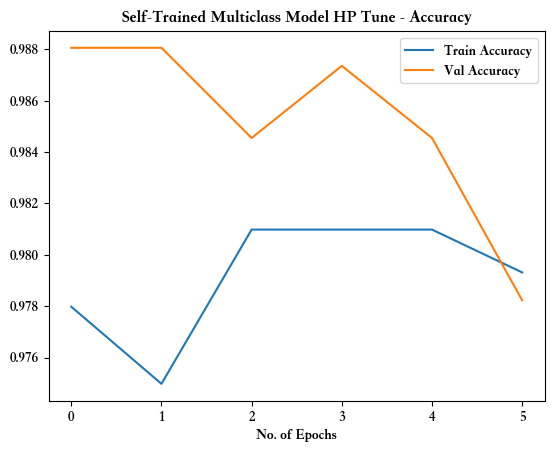

In [22]:
plt.plot(history_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Val Accuracy')
plt.title('Self-Trained Multiclass Model HP Tune - Accuracy')
plt.xlabel('No. of Epochs')
plt.legend();

The train accuracy is only slightly higher than the validation accuracy. There is very little evidence of overfitting, as such the model is able to generalize well to unseen data.

#### 6.7.3 AUC over training epochs

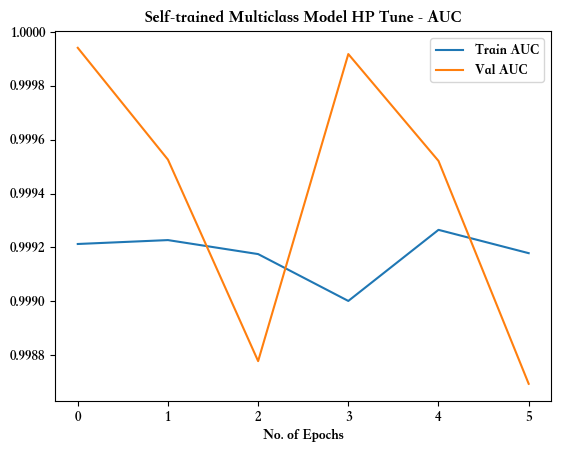

In [23]:
plt.plot(history_best.history['auc'], label='Train AUC')
plt.plot(history_best.history['val_auc'], label='Val AUC')
plt.title('Self-trained Multiclass Model HP Tune - AUC')
plt.xlabel('No. of Epochs')
plt.legend();

AUC is a measure of the ability of a classifier to distinguish between clsses. The higher the AUC, the better the model's performance, with a perfect AUC score being 1. In this aspect, the model is performing very well as it has the almost perfect score of 1.

#### 6.7.4 Summary of Metrics

We will compile these metrics to compare with the model before hyperparameters tuning.

In [24]:
summary_metrics = {}

summary_metrics['Train loss'] = history_best.history['loss'][-1]
summary_metrics['Val loss'] = history_best.history['val_loss'][-1]
summary_metrics['Train accuracy'] = history_best.history['accuracy'][-1]
summary_metrics['Val accuracy'] = history_best.history['val_accuracy'][-1]
summary_metrics['Train AUC'] = history_best.history['auc'][-1]
summary_metrics['Val AUC'] = history_best.history['val_auc'][-1]

print('Summary of metrics for Self-Trained Multiclass Model HP Tune')
print(summary_metrics)

Summary of metrics for Self-Trained Multiclass Model HP Tune
{'Train loss': 0.06317596137523651, 'Val loss': 0.06603894382715225, 'Train accuracy': 0.9793161153793335, 'Val accuracy': 0.978230357170105, 'Train AUC': 0.9991787672042847, 'Val AUC': 0.9986943602561951}


#### 6.7.5 Confusion Matrix

A confusion matrix shows the detailed breakdown of the model's predictions and the actual classes.

In [26]:
# Make predictions on the test data
predictions = best_model.predict(val_generator)

# Extract true labels
y_true = val_generator.classes

# Extract predicted labels
y_pred = np.argmax(predictions, axis=1)

2024-05-10 04:56:25.225006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


89/89 [==============================] - 7s 81ms/step


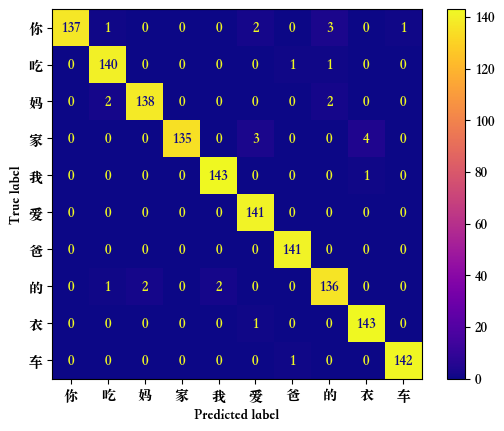

In [29]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
            display_labels=['你', '吃', '妈', '家', '我',
            '爱','爸', '的', '衣', '车'])
disp.plot(cmap='plasma')
plt.show()

The diagonal line from top left to bottom right represents the true positives (data that was correctly predicted). The diagonal line is almost all yellow, which is the higher end of the spectrum. The number of data outside of the diagonal line is mostly under 3. This shows that the model is able to produce a highly accurate prediction.

### 6.8 Comparison Before and After Tuning

Here is a visual comparison of the performance of the self-trained CNN multiclass before and after tuning.

In [3]:
# Compile metrics from output cell of previous notebooks
model_1 = {'Model': 'self_trained_multiclass', 'Train loss': 0.14485211670398712, 'Val loss': 0.12519174814224243, 'Train accuracy': 0.9532943964004517, 'Val accuracy': 0.9599719047546387, 'Train AUC': 0.9975926876068115, 'Val AUC': 0.9987270832061768}
model_2 = {'Model': 'self_trained_multiclass_hp_tune', 'Train loss': 0.06317596137523651, 'Val loss': 0.06603894382715225, 'Train accuracy': 0.9793161153793335, 'Val accuracy': 0.978230357170105, 'Train AUC': 0.9991787672042847, 'Val AUC': 0.9986943602561951}

# Create dataframe
df = pd.DataFrame([model_1, model_2])

In [31]:
display(df)

,Model,Train loss,Val loss,Train accuracy,Val accuracy,Train AUC,Val AUC
0,self_trained_multiclass,0.144852,0.125192,0.953294,0.959972,0.997593,0.998727
1,self_trained_multiclass_hp_tune,0.063176,0.066039,0.979316,0.978230,0.999179,0.998694


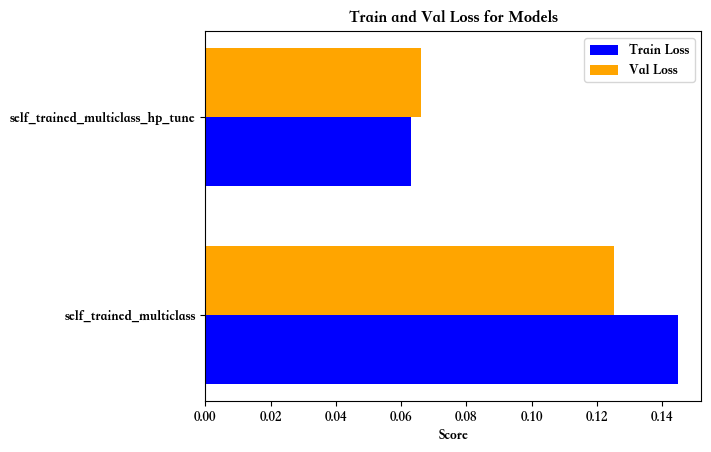

In [32]:
# To plot horizontal bar graphs for train and val loss
models = df['Model']
bar_width = 0.35

# Set positions for the bars
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plot train scores for Model A and Model B
plt.barh(r1, df['Train loss'], color='blue', height=bar_width, label='Train Loss')

# Plot test scores for Model A and Model B
plt.barh(r2, df['Val loss'], color='orange', height=bar_width, label='Val Loss')

# Add labels and title
plt.xlabel('Score')
plt.title('Train and Val Loss for Models')
plt.yticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend();

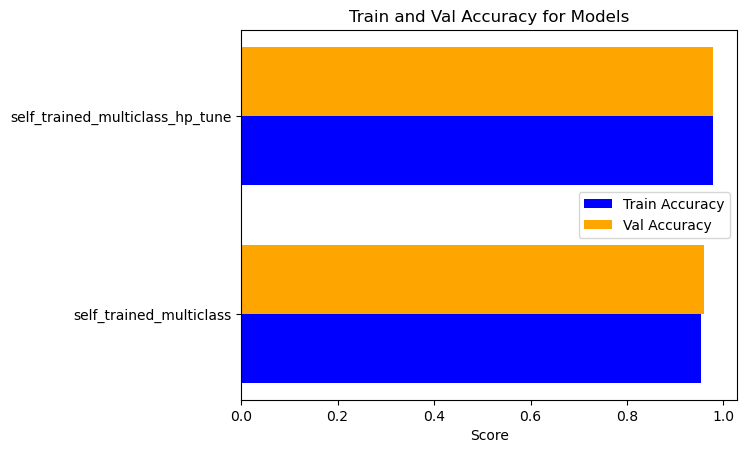

In [4]:
# To plot horizontal bar graphs for train and val accuracy
models = df['Model']
bar_width = 0.35

# Set positions for the bars
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plot train scores for Model A and Model B
plt.barh(r1, df['Train accuracy'], color='blue', height=bar_width, label='Train Accuracy')

# Plot test scores for Model A and Model B
plt.barh(r2, df['Val accuracy'], color='orange', height=bar_width, label='Val Accuracy')

# Add labels and title
plt.xlabel('Score')
plt.title('Train and Val Accuracy for Models')
plt.yticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend(loc='best');

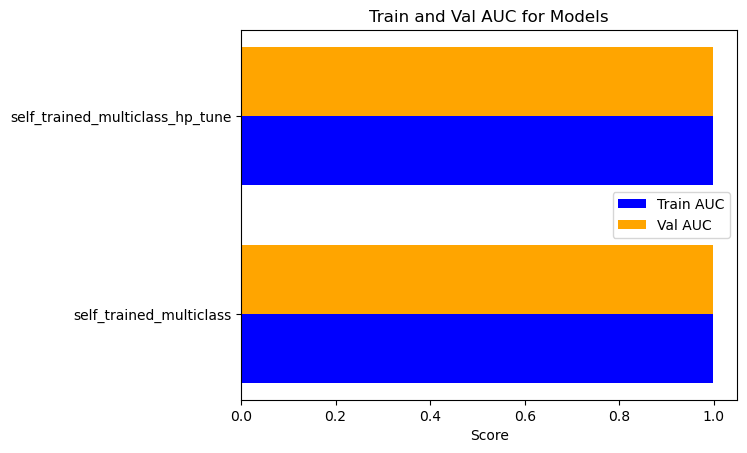

In [5]:
# To plot horizontal bar graphs for train and val AUC
models = df['Model']
bar_width = 0.35

# Set positions for the bars
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plot train scores for Model A and Model B
plt.barh(r1, df['Train AUC'], color='blue', height=bar_width, label='Train AUC')

# Plot test scores for Model A and Model B
plt.barh(r2, df['Val AUC'], color='orange', height=bar_width, label='Val AUC')

# Add labels and title
plt.xlabel('Score')
plt.title('Train and Val AUC for Models')
plt.yticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend(loc='best');

### 6.9 Summary

On the whole, there has been some improvement observed after performing hyperparameter tuning:
  
1. The loss was reduced from about 0.12 to about 0.6.
  
2. There is an increase in the accuracy score from 0.9600 to 0.9782.
  
3. The AUC score is almost 1 to start off with.
  
4. There has been some improvement in the confusion matrix, with lesser incorrect prediction.
  
With this high level of accuracy, we are confident to train more Chinese characters with additional computational capabilities, and to deploy it for further development.  

Update: we have successfully deployed this model into a working user interface onto Streamlit Cloud, and it can be accessed via this [link](https://hanzi-hero.streamlit.app/): https://hanzi-hero.streamlit.app/. We have documented the deployment codes and limitations in the next repository `hanzi_hero_streamlit`.